In [ ]:
# default_exp core

# core 

> Core functions for analyzing CRISPR screens

## Log-normalizing Data

In [ ]:
# export 
import numpy as np

def lognorm(reads):
    """
    Standardize read counts by calculating reads per million, 
    adding a pseudo-count of one, and taking the log2
    
    reads: numpy or pandas array |
    returns: numpy or pandas array
    """
    reads_per_million = (reads/reads.sum())*(10**6)
    lognormed_reads = np.log2(reads_per_million + 1)
    return lognormed_reads


def lognorm_columns(reads_df, columns):
    """
    Calculate lognorms for specified columns
    
    reads_df: dataframe |
    columns: list |
    returns: lognorm dataframe
    """
    lognorm_df = reads_df.copy()
    lognorm_df[columns] = lognorm_df[columns].apply(lognorm)
    return lognorm_df

To demonstrate the functionality of this module we'll use read counts from [Sanson et al. 2018](https://doi.org/10.1038/s41467-018-07901-8).

In [ ]:
import pandas as pd
import seaborn as sns

supp_reads = 'https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-07901-8/MediaObjects/41467_2018_7901_MOESM4_ESM.xlsx'
read_counts = pd.read_excel(supp_reads,
                            sheet_name = 'A375_orig_tracr raw reads', 
                            header = None,
                            skiprows = 3, 
                            names = ['sgRNA Sequence', 'pDNA', 'A375_RepA', 'A375_RepB'])

read_counts

,sgRNA Sequence,pDNA,A375_RepA,A375_RepB
0,AAAAAAAATCCGGACAATGG,522,729,774
1,AAAAAAAGGATGGTGATCAA,511,1484,1393
2,AAAAAAATGACATTACTGCA,467,375,603
3,AAAAAAATGTCAGTCGAGTG,200,737,506
4,AAAAAACACAAGCAAGACCG,286,672,352
...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,514,2878,303
77437,TTTTACCTTGTTCACATGGA,828,3896,3367
77438,TTTTGACTCTAATCACCGGT,588,2725,2498
77439,TTTTTAATACAAGGTAATCT,503,2209,1785


Note that the read counts have a long right tail

<AxesSubplot:xlabel='pDNA', ylabel='Density'>

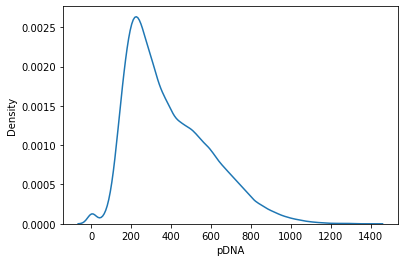

In [ ]:
sns.kdeplot(read_counts['pDNA'])

To mitigate this tail and account for sequencing biases we log-normalize read counts by taking $$\log_2 \left ( \frac{\text{reads}}{\text{total reads in condition}} * 10^6 + 1 \night )$$

<AxesSubplot:xlabel='pDNA', ylabel='Density'>

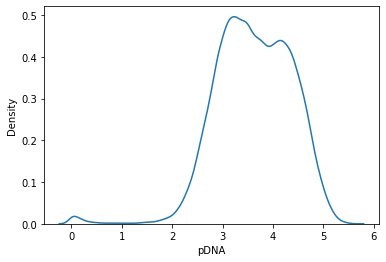

In [ ]:
lognorms = lognorm_columns(reads_df=read_counts, columns=['pDNA', 'A375_RepA', 'A375_RepB'])
sns.kdeplot(lognorms['pDNA'])

## Filter pDNA

In [ ]:
# export
def filter_pdna(lognorm_df, pdna_cols, z_low=-3, z_high=None):
    """
    Filter the lognorm dataframe based on the z_scored lognorms of pDNA
    
    lognorm_df: dataframe |
    pdna_cols: list |
    z_low: int or None, lower range of z-scores to filter |
    z_high: int or None, uppper range of z-scores to filter |
    returns: filtered dataframe
    """
    filtered_lognorms = lognorm_df.copy()
    z_scored_cols = []
    for pdna in pdna_cols:
        z_col = pdna + '_z'
        filtered_lognorms[z_col] = (filtered_lognorms[pdna] - filtered_lognorms[pdna].mean())/filtered_lognorms[pdna].std()
        z_scored_cols.append(z_col)
    if z_low:
        filtered_lognorms = filtered_lognorms[filtered_lognorms[z_scored_cols].min(axis = 1) > z_low] # allow for multiple pDNA columns
    if z_high:
        filtered_lognorms = filtered_lognorms[filtered_lognorms[z_scored_cols].max(axis = 1) < z_high]
    filtered_lognorms = filtered_lognorms.drop(z_scored_cols, axis=1)
    return filtered_lognorms

Note that there's a small number of sgRNAs with low pDNA abundance. We'll fiter out any sgRNAs with lognormed pDNA less than the mean minus 3 standard deviations. 

In [ ]:
filtered_lognorms = filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA'])
lognorms.shape[0] - filtered_lognorms.shape[0]

576

<AxesSubplot:xlabel='pDNA', ylabel='Density'>

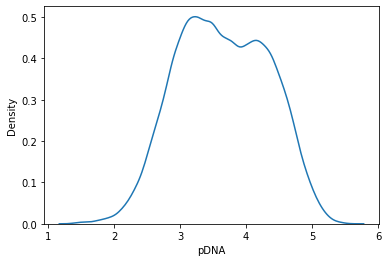

In [ ]:
sns.kdeplot(filtered_lognorms['pDNA'])

In [ ]:
assert ((filtered_lognorms['pDNA'] - lognorms['pDNA'].mean())/lognorms['pDNA'].std()).min() > -3

## Calculate log-fold changes

In [ ]:
# export
def calculate_lfcs(lognorm_df, ref_col=None, target_cols=None, ref_map=None):
    """
    Calculate log-fold changes between reference column and target columns
    
    lognorm_df: dataframe |
    ref_col: str or None, if str then target_col must also be present |
    target_col: list or None |
    ref_map: dict or None, key-value pairs correspond to target-reference conditions |
    returns: dataframe with log-fold changes
    """
    lfc_df = lognorm_df.copy()
    if (ref_col is not None) & (target_cols is not None):
        lfc_df[target_cols] = lfc_df[target_cols].sub(lfc_df[ref_col], axis=0)
        lfc_df = lfc_df.drop(ref_col, axis=1)
    elif ref_map is not None:
        for target_col, ref_col in ref_map.items():
            # use lognorms in case columns double as target and ref
            lfc_df[target_col] = lognorm_df[target_col] - lognorm_df[ref_col] 
        for ref_col in set(ref_map.values()):
            if ref_col not in ref_map.keys(): # not a target condition as well
                lfc_df = lfc_df.drop(ref_col, axis=1)
    else:
        raise ValueError('Either ref_col and target_cols or ref_map must be present')
    return lfc_df

We'll calculate log-fold changes from the pDNA reference. Since we only have one reference condition we can supply the calculate_lfcs function with the ref_col and target_cols arguments.

In [ ]:
lfc_df = calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA', target_cols=['A375_RepA', 'A375_RepB'])

Alternatively we can supply a ref_map, which is useful when we have more than one reference condition

In [ ]:
lfc_df2 = calculate_lfcs(filtered_lognorms, ref_map = {'A375_RepA': 'pDNA', 'A375_RepB': 'pDNA'})
assert lfc_df.equals(lfc_df2)

We can use seaborn's [clustermap function](https://seaborn.pydata.org/generated/seaborn.clustermap.html) to plot a clustermap of replicate correlations

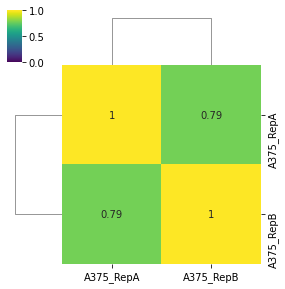

In [ ]:
import seaborn as sns

sns.clustermap(lfc_df.corr(), vmin= 0, cmap= 'viridis', annot= True, figsize= (4,4))

Since we only have two conditions it's also easy to visualize replicates as a point densityplot using [gpplot](https://github.com/gpp-rnd/gpplot)

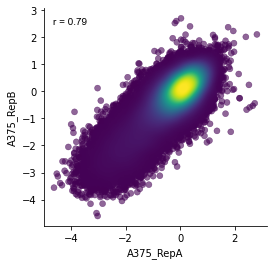

In [ ]:
import gpplot
import matplotlib.pyplot as plt

plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=lfc_df, x='A375_RepA', y='A375_RepB')
gpplot.add_correlation(data=lfc_df, x='A375_RepA', y='A375_RepB')
sns.despine()

### Avergage log-fold changes across replicates

In [ ]:
#export 
from pandas.api.types import is_numeric_dtype

def get_condition(condition_name, sep, condition_indices):
    """Split replicate name from condition name"""
    split_condition = condition_name.split(sep)
    relevant_condition_elements = [split_condition[i] for i in condition_indices]
    condition = sep.join(relevant_condition_elements)
    return condition

def average_replicate_lfcs(lfcs, guide_col, condition_indices, sep='_', lfc_cols=None, 
                           condition_name='condition', lfc_name='avg_lfc'):
    """
    Average log-fold changes of sgRNAs across replicates
    
    lfcs: dataframe |
    guide_col: str, sgrna column name |
    condition_indices: list of int, specifies which elements to use 
        for conditions after separating column names with sep |
    sep: str, separator in column names |
    lfc_cols: list or None, lfc column(s) to melt. If None use all columns that are not guide_col |
    condition_name: str, name of condition columns |
    lfc_name: str, name of new column with log-fold changes |
    returns: dataframe of average lfcs
    """
    if lfc_cols is None:
        if not (lfcs.drop(guide_col,axis=1)
                .apply(is_numeric_dtype, axis=0).all()):
            raise ValueError('If lfc_cols are not supplied then all columns except guide_col must be numeric')
    long_lfcs = (lfcs.melt(id_vars=guide_col, value_vars=lfc_cols, 
                           var_name=condition_name, value_name=lfc_name)
                 .reset_index())
    conditions = long_lfcs[condition_name].unique()
    condition_map = {cond: get_condition(cond, sep, condition_indices) for cond in conditions}
    long_lfcs[condition_name] = (long_lfcs[condition_name]
                                 .replace(condition_map))
    avg_lfcs = (long_lfcs.groupby([guide_col, condition_name])
                .agg(avg_lfc = (lfc_name, 'mean'), 
                     n_obs = (lfc_name, 'count'))
                .reset_index())
    avg_lfcs = avg_lfcs.rename({'avg_lfc': lfc_name}, axis=1)
    return avg_lfcs

Since we see a strong correlation, we'll average the log-fold change of each sgRNA across replicates

In [ ]:
avg_replicate_lfc_df = average_replicate_lfcs(lfcs=lfc_df, guide_col='sgRNA Sequence', condition_indices=[0])
assert np.abs(avg_replicate_lfc_df.shape[0] - read_counts.shape[0]) < 1000 

### Average log-fold changes by gene

In [ ]:
# export
def group_pseudogenes(annotations, pseudogene_size,
                      gene_col, control_regex, seed=7):
    """
    Remap annotations dataframe such that control genes are grouped into 
    pseudo-genes
    
    annotations: dataframe |
    pseudogene_size: int |
    gene_col: str |
    control_regex: list of str, regular expressions to identify groups of 
        pseudogenes |
    seed: int, random seed for reproducible outputs |
    returns: dataframe of annotations with controls grouped into pseudogenes |
    """
    remapped_annotations = annotations.copy()
    genes = remapped_annotations[gene_col]
    control_remap = {}
    for regex in control_regex:
        control_genes = genes[genes.str.contains(regex)].to_list()
        np.random.seed(seed)
        np.random.shuffle(control_genes) # shuffle mutates existing variable  
        n_controls = len(control_genes)
        for i in range(n_controls):
            gene = control_genes[i]
            # Use modulo to get the right number of groupings
            gene_number = i % np.ceil(n_controls / pseudogene_size)
            control_remap[gene] = regex + '_' + str(int(gene_number))
    remapped_annotations[gene_col] = remapped_annotations[gene_col].replace(control_remap)
    return remapped_annotations

Before combining sgRNAs at the gene level, it's sometimes helpful to group controls into pseudo-genes so they're easier to compare with target genes

In [ ]:
guide_annotations = pd.read_excel(supp_reads,
                                  sheet_name='sgRNA annotations')
guide_annotations

,sgRNA Sequence,Annotated Gene Symbol,Annotated Gene ID
0,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,ZNF470,388566
...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,NEPRO,25871
77437,TTTTACCTTGTTCACATGGA,NO_CURRENT_997,NO_CURRENT_997
77438,TTTTGACTCTAATCACCGGT,NO_CURRENT_998,NO_CURRENT_998
77439,TTTTTAATACAAGGTAATCT,NO_CURRENT_999,NO_CURRENT_999


In [ ]:
remapped_annotations = group_pseudogenes(annotations=guide_annotations, pseudogene_size=4, 
                                         gene_col='Annotated Gene Symbol', 
                                         control_regex=['NO_CURRENT'])
control_genes = remapped_annotations.loc[remapped_annotations['Annotated Gene Symbol'].str.contains('_'), 'Annotated Gene Symbol']
assert control_genes.value_counts().max() == 4
assert control_genes.value_counts().min() == 4
assert len(control_genes) == 1000
remapped_annotations

,sgRNA Sequence,Annotated Gene Symbol,Annotated Gene ID
0,AAAAAAAATCCGGACAATGG,SLC25A24,29957
1,AAAAAAAGGATGGTGATCAA,FASTKD3,79072
2,AAAAAAATGACATTACTGCA,BCAS2,10286
3,AAAAAAATGTCAGTCGAGTG,GPR18,2841
4,AAAAAACACAAGCAAGACCG,ZNF470,388566
...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,NEPRO,25871
77437,TTTTACCTTGTTCACATGGA,NO_CURRENT_181,NO_CURRENT_997
77438,TTTTGACTCTAATCACCGGT,NO_CURRENT_63,NO_CURRENT_998
77439,TTTTTAATACAAGGTAATCT,NO_CURRENT_154,NO_CURRENT_999


In [ ]:
# export
from pandas.api.types import is_list_like

def average_gene_lfcs(lfcs, annotations, gene_col, condition_col='condition', 
                      lfc_col='avg_lfc', merge_on=None, lfc_merge_on=None,
                      annotation_merge_on=None, controls_to_z=None):
    """
    Average log-fold changes of sgRNAs across genes
    
    lfcs: dataframe |
    annotations: dataframe, mapping between sgRNAs and genes |
    gene_col: str, column which uniquely identifies a gene |
    condition_col: str, column which uniquely identifies experimental conditions |
    lfc_col: str, name of value to average |
    merge_on: str or None, name of sgRNA column to merge on. Must be present in both 
        lfc and annotation dataframes if supplied, 
        otherwise supply unique merge column to each |
    lfc_merge_on: str or None, name of sgRNA column to merge on |
    annotation_merge_on: str, name of sgRNA column to merge on. Present in 
        annotation dataframe if supplied |
    controls_to_z: str or list of str or None, if supplied specifies
        control genes for z-scoring log-fold changes
        if string then interpreted as a regex 
        otherwise interpreted as a list of gene names found in gene_col |
    returns: dataframe, lfcs and (optionally) z-scores averaged by gene
    """
    annotated_lfcs = lfcs.merge(annotations, how='inner', on=merge_on, left_on=lfc_merge_on, right_on=annotation_merge_on)
    gene_lfcs = (annotated_lfcs
                 .groupby([condition_col, gene_col])
                 .agg(avg_lfc = (lfc_col, 'mean'),
                      n_obs = (lfc_col, 'count'))
                 .reset_index())
    gene_lfcs = gene_lfcs.rename({'avg_lfc': lfc_col}, axis=1)
    if controls_to_z != None:
        if isinstance(controls_to_z, str):
            control_lfcs = annotated_lfcs[annotated_lfcs[gene_col].str.contains(controls_to_z)]
        elif is_list_like(controls_to_z):
            control_lfcs = annotated_lfcs[annotated_lfcs[gene_col].isin(controls_to_z)]
        else:
            raise ValueError('Must Supply a string or list-like object to controls_to_z')
        control_stats = (control_lfcs.groupby(condition_col)
                         .agg(ctl_mean = (lfc_col, 'mean'), 
                              ctl_sd = (lfc_col, 'std'))
                         .reset_index())
        gene_lfcs = (gene_lfcs.merge(control_stats, how='inner', on=condition_col))
        gene_lfcs[lfc_col + '_z-score'] = (gene_lfcs[lfc_col] - gene_lfcs['ctl_mean'])/(gene_lfcs['ctl_sd']/np.sqrt(gene_lfcs['n_obs']))
    return gene_lfcs

We'll average the sgRNA log-fold changes by gene

In [ ]:
gene_lfcs = average_gene_lfcs(lfcs=avg_replicate_lfc_df, annotations=remapped_annotations, gene_col='Annotated Gene Symbol',
                              merge_on='sgRNA Sequence', controls_to_z='NO_CURRENT')
assert np.abs(gene_lfcs.shape[0] - 20000) < 1000
control_z_scores = gene_lfcs.loc[gene_lfcs['Annotated Gene Symbol'].str.contains('_'), 'avg_lfc_z-score']
assert np.abs(control_z_scores.mean()) < 0.1
assert np.abs(control_z_scores.std() - 1) < 0.1
gene_lfcs

,condition,Annotated Gene Symbol,avg_lfc,n_obs,ctl_mean,ctl_sd,avg_lfc_z-score
0,A375,A1BG,-0.084621,3,0.680505,0.277409,-4.777195
1,A375,A1CF,0.500314,4,0.680505,0.277409,-1.299099
2,A375,A2M,0.288629,4,0.680505,0.277409,-2.825256
3,A375,A2ML1,-0.481786,4,0.680505,0.277409,-8.379618
4,A375,A3GALT2,0.059362,4,0.680505,0.277409,-4.478172
...,...,...,...,...,...,...,...
19358,A375,ZYG11A,-0.280137,4,0.680505,0.277409,-6.925816
19359,A375,ZYG11B,0.215013,4,0.680505,0.277409,-3.355994
19360,A375,ZYX,-0.182864,4,0.680505,0.277409,-6.224519
19361,A375,ZZEF1,0.104225,4,0.680505,0.277409,-4.154730


## Calculate ROC-AUC between essential and non-essential genes

In [ ]:
# export
from sklearn.metrics import roc_auc_score

def get_roc_aucs(lfcs, tp_genes, fp_genes, gene_col, score_col='avg_lfc', group_col='condition'):
    """
    Calculate the ROC-AUC between true positive and false positive gene sets
    
    lfcs: dataframe |
    tp_genes: list-like, true positive genes |
    fp_genes: list-like, false positive genes |
    gene_col: str |
    score_col: str, column to use for ranking genes from smallest to largest |
    group_col: list, columns to use for grouping genes |
    returns: datafrme of roc_aucs
    """
    roc_df = lfcs.copy()
    roc_df = roc_df[roc_df[gene_col].isin(tp_genes) | 
                    roc_df[gene_col].isin(fp_genes)]
    roc_df['tp'] = roc_df[gene_col].isin(tp_genes)
    roc_aucs = (roc_df.groupby(group_col)
                .apply(lambda df: roc_auc_score(df['tp'], -df[score_col]))
                .reset_index(name='ROC-AUC'))
    return roc_aucs

Finally, to evaluate the quality each screen, we'll calculate the ROC-AUC between [essential](https://doi.org/10.1016/j.cell.2015.11.015) and [nonessential](https://doi.org/10.15252/msb.20145216) genes for each condition

In [ ]:
import requests

noness_file = "https://www.embopress.org/action/downloadSupplement?doi=10.15252%2Fmsb.20145216&file=msb145216-sup-0001-DatasetS1.xlsx"
noness_genes = (pd.read_excel(requests.get(noness_file).content, sheet_name='ReferenceSets', usecols=['Nonessential Genes (NE)'])
                .rename({'Nonessential Genes (NE)': 'gene'}, axis=1))

ess_file = 'http://tko.ccbr.utoronto.ca/Data/core-essential-genes-sym_HGNCID'
ess_genes = pd.read_table(ess_file, names=['gene', 'gene_id'])

/Users/pdeweird/.local/share/virtualenvs/poola-tuJn2lJU/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:308: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
roc_aucs = get_roc_aucs(lfcs=gene_lfcs, tp_genes=ess_genes.gene, fp_genes=noness_genes.gene, gene_col='Annotated Gene Symbol')
assert roc_aucs['ROC-AUC'][0] > 0.9
roc_aucs

,condition,ROC-AUC
0,A375,0.976469


We can see this visually as well that essentials deplete the most followed by nonessentials and control genes

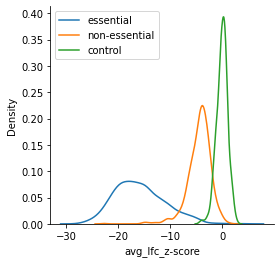

In [ ]:
plt.subplots(figsize=(4,4))
sns.kdeplot(gene_lfcs.loc[gene_lfcs['Annotated Gene Symbol'].isin(ess_genes.gene), 'avg_lfc_z-score'], label='essential')
sns.kdeplot(gene_lfcs.loc[gene_lfcs['Annotated Gene Symbol'].isin(noness_genes.gene), 'avg_lfc_z-score'], label='non-essential')
sns.kdeplot(gene_lfcs.loc[gene_lfcs['Annotated Gene Symbol'].str.contains('_'), 'avg_lfc_z-score'], label='control')
sns.despine()
plt.legend()